<hr style="height:2px;border:none"/>
<h1 align='center'> <img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />

INF-395 / 477 / 577 Tarea 2 Redes Neuronales Artificiales - 2020-2 </h1>

<H3 align='center'> Integrantes: Kevin Reyes - Diego Quezada </H3>
<hr style="height:2px;border:none"/>


**Temas**  
* Manipulaciones en tensorflow, keras, pandas y numpy
* Recurrent Neural Networks
* LSTM, GRU
* Autoencoders
* GAN

**Formalidades**  
* Equipos de trabajo de 2 personas (*Ambos estudiantes deben estar preparados para presentar la tarea el día de la entrega*)
* El entregable debe ser un _Jupyter Notebook_ incluyendo los códigos utilizados, los resultados, los gráficos realizados y comentarios. Debe seguir una estructura similar a un informe (se debe introducir los problemas a trabajar, presentar los resultados y discutirlos). Si lo prefiere puede entregar un _Jupyter Notebook_ por pregunta o uno para toda la tarea, con tal de que todos los entregables estén bien identificados y se encuentren en el mismo repositorio de _Github_.
* Se debe preparar una presentación del trabajo realizado y sus hallazgos. El presentador será elegido aleatoriamente y deberá apoyarse en el _Jupyter Notebook_ que entregarán. 
* Formato de entrega: envı́o de link del repositorio en _Github_ ( en caso de ser repositorio privado, invitar como colaborador al usuario de github "Aerlio") al correo electrónico del ayudante (*<tomas.ochoa.14@sansano.usm.cl>*), en copia al profesor (*<cvalle@inf.utfsm.cl>*). Especificar el siguiente asunto: [INF395/477/577-2020 Tarea 2]
* Fecha de entrega y presentaciones: 8 de Enero. Hora límite de entrega: 23:00. Cualquier _commit_ luego de la hora límite no será evaluado. Se realizará descuento por atrasos en envío del mail. 

<hr style="height:2px;border:none"/>

La tarea se divide en tres partes:

[1.](#primero) RNNs para series de tiempo  <br>
[2.](#segundo) RNNs para texto <br>
[3.](#tercero) Autoencoders para imágenes <br>
[3.](#cuarto) GANs para imágenes <br>

La tarea tiene ejemplos de códigos con los cuales pueden guiarse en gran parte, sin embargo solo son guías y pueden ser creativos al momento de resolver la tarea. Soluciones creativas o elegantes serán valoradas. También en algunas ocaciones se hacen elecciones arbitrarias, ustedes pueden realizar otras elecciones con tal de que haya una pequeña justificación de por qué su elección es mejor o equivalente.
Recuerden intercalar su código con comentarios y con celdas _Markdown_ con los comentarios de la pregunta y con cualquier analisis, fórmula o explicación que les parezca relevante para justificar sus procedimientos. 
Noten que en general cuando se les pide elegir algo o proponer algo no se evaluará mucho la elección en si, en cambio la argumentación detrás de la elección será lo más ponderado.

**Es ÁLTAMENTE recomendado realizar esta tarea en _Colab_ de Google (https://colab.research.google.com/notebooks/intro.ipynb#recent=true), con el fin de no depender del rendimiento de su computador personal al momento de entrenar redes neuronales y poder compartir de forma fácil sus avances con su compañer@ de trabajo.** Si bien conlleva sus pros y contras utilizar _Colab_ , existirá una curva de aprendizaje personal que lo ayudará a sacar el mayor provecho a esta herramienta, por ejemplo aprendiendo a guardar los avances realizados, evitando tener que ejecutar todo el código cada vez que se abra _Colab_ . *Tip: Una vez abierto un notebook en _Colab_ ir a **entorno de ejecución**->**Cambiar tipo de entorno de ejecución**, y seleccionár TPU como acelerador por hardware para redes recurrentes y GPU para redes convolucionales.*.

# 1. RNNs para series de tiempo

Las redes neuronales recurrentes (RNNs) son una red neuronal profunda que tiene, como su nombre indica, entradas recurrentes en la capa oculta, es decir, la salida de una capa oculta se retroalimenta a sí misma. La memoria neuronal es la capacidad impartida a un modelo para retener la entrada de los pasos de tiempo anteriores cuando la entrada es secuencial. En términos simples, cuando nuestro problema está asociado con una secuencia de datos como una oración o una serie temporal o la letra de una canción, el modelo tiene que recordar los estados previos de la entrada para funcionar.

<h1 align='center'> <img src="https://www.hobodataloggers.com.au/images/thumbs/0007371_hobo-weather-station-kits_510.jpeg" width="50%" height="100%" /> </h1>

En esta pregunta trabajaremos con datos obtenidos presumiblemente de una estación meteorológica, los cuales se obtienen desde el sitio https://www.kaggle.com/dronio/SolarEnergy, este dataset contiene mediciones de los últimos 4 meses. Nuestro objetivo será predecir el nivel de radiación solar para la próximas 24 horas.


##### I) Iniciaremos cargando los datos. Para esto necesitará crear una cuenta en kaggle, dirigirse a su perfil, ir a Account, y en la sección API apretar _Create new API token_ , se descargará un archivo kaggle.json, ábralo como archivo de texto y obtenga su username y key. Luego ejecute el siguiente código (desconozco por qué pero a veces hay que ejecutar el código 2 veces para que funcione). Solución obtenida desde el hilo: https://gist.github.com/jayspeidell/d10b84b8d3da52df723beacc5b15cb27

In [7]:
username="diegoquezada21"
key="afb1882970f4ac5726f12dda7bf92f7c"
!pip install -q kaggle
api_token = {"username":username,"key":key}
import json
import zipfile
import os
os.environ['KAGGLE_USERNAME'] = str(username)
os.environ['KAGGLE_KEY'] = str(key)
!kaggle datasets download -d dronio/SolarEnergy
if not os.path.exists("/content/solar_prediction"):
    os.makedirs("/content/solar_prediction")
os.chdir('/content/solar_prediction')
for file in os.listdir():
    if file[-4:]==".zip":
      zip_ref = zipfile.ZipFile(file, 'r')
      zip_ref.extractall()
      zip_ref.close()
!ls

SolarEnergy.zip: Skipping, found more recently modified local copy (use --force to force download)
SolarEnergy.zip  SolarPrediction.csv


Procederemos a ordenar la serie temporalmente a continuación.

In [8]:
import random

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime
from pytz import timezone
import pytz
hawaii= timezone('Pacific/Honolulu') # to convert unixtime
dataset = pd.read_csv('SolarPrediction.csv') # read data
dataset = dataset.sort_values(['UNIXTime'], ascending = [True]) #sort data
dataset.index =  pd.to_datetime(dataset['UNIXTime'], unit='s') # make unix pandas dataframe index
dataset.index = dataset.index.tz_localize(pytz.utc).tz_convert(hawaii) # convert unixtime to timestamp
dataset.drop(['Data','Time','TimeSunRise','TimeSunSet',"UNIXTime"], inplace=True, axis=1) # drop extra-time variables
dataset.head(20)

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed
UNIXTime,,,,,,
2016-09-01 00:00:08-10:00,2.58,51,30.43,103,77.27,11.25
2016-09-01 00:05:10-10:00,2.83,51,30.43,103,153.44,9.00
2016-09-01 00:20:06-10:00,2.16,51,30.43,103,142.04,7.87
2016-09-01 00:25:05-10:00,2.21,51,30.43,103,144.12,18.00
2016-09-01 00:30:09-10:00,2.25,51,30.43,103,67.42,11.25
2016-09-01 00:45:04-10:00,2.15,51,30.43,103,67.85,4.50
2016-09-01 00:50:06-10:00,2.07,51,30.43,103,156.58,1.12
2016-09-01 00:55:04-10:00,2.06,52,30.43,103,69.98,7.87
2016-09-01 01:00:07-10:00,2.10,52,30.43,103,92.15,4.50


**Comentario:** Se puede observar inmediatamente que existen datos faltantes, los cuales no son declarados. Dado que de los 6 datos impresos se puede inferir que el timestep es de 5 minutos, y faltarían los datos del instante 2016-09-01 ~00:10:00 y 2016-09-01 ~00:15:00

A continuación se proveen comandos con los cuales se puede observar cómo a partir del timestamp generado se puede categorizar con comandos simples el dataset según minuto del día, hora del día, mes del año, y día del año. Los cuales se ocuparán durante la tarea. 

In [10]:
dataset.index.minute,dataset.index.hour,dataset.index.month,dataset.index.dayofyear

(Int64Index([ 0,  5, 20, 25, 30, 45, 50, 55,  0,  5,
             ...
             10, 15, 20, 25, 30, 35, 40, 45, 50, 55],
            dtype='int64', name='UNIXTime', length=32686),
 Int64Index([ 0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
             ...
             23, 23, 23, 23, 23, 23, 23, 23, 23, 23],
            dtype='int64', name='UNIXTime', length=32686),
 Int64Index([ 9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
             ...
             12, 12, 12, 12, 12, 12, 12, 12, 12, 12],
            dtype='int64', name='UNIXTime', length=32686),
 Int64Index([245, 245, 245, 245, 245, 245, 245, 245, 245, 245,
             ...
             366, 366, 366, 366, 366, 366, 366, 366, 366, 366],
            dtype='int64', name='UNIXTime', length=32686))

##### II) Para poder idententificar los Missing Values, y poder contar de manera segura con días de 24 horas, ejecute el siguiente código. **Explique** la funcionalidad del código escrito, escribiendo en forma de comentario (#) sobre las líneas de este código.

In [11]:
import time

t1=time.time()
# cantidad de horas al dia (24), cantidad de datos por hora (12) cantidad de dias en el dataset. La segunda 
# dimensión corresponde al número de columnas del dataset + la radiación a predecir.
new_data=np.nan*np.zeros((24*12*(len(np.unique(dataset.index.dayofyear))),1+len(dataset.columns)), dtype=object) 
# new data es como el arreglo en donde deberiamos tener los datos de todos los dias.
# hace el unique de las fechas asociadas a todos los datos
days=np.unique(np.asarray([str(dataset.index[i]).split(" ")[0] for i in range(dataset.shape[0])])) 

# Función para obtener el string del minuto en formato de dos digitos
def min_to_str(min): #min de minutos
  if min==0: min="00"
  elif min==5: min="0"+str(min) #05
  else: min=str(min) # se deja igual en otro caso, ya tendremos dos digitos
  return(min)

# Data que deberia tener, se genera un nuevo data set que incluira aquellos registros faltantes del dataset original,
# se inicializan las fechas correspondientes a cada dato
for i in range(new_data.shape[0]): # para cada posicion del dato i esimo en mi nuevo dataset (mayor que el original)
  hr=i//12-24*((i//12)//24) # horas, valores del 0 al 23
  if hr==0: hr="00"
  elif 0<hr<10: hr="0"+str(hr) #09, 08 de la manana por ejemplo. Estos valores se repiten mucho, hay 12 por cada hora en general
  else: hr=str(hr) #10, 12, 23 por ejemplo
  min=5*i-60*((5*i)//60) #minutos, del 0 al 55
  day=(i//12)//24 #dias, del 0 al 33984 - 1
  new_data[i,0]=days[day]+" "+str(hr)+":"+min_to_str(min)+":00" ## fecha formato dia hora min y segundos en 00


verbose,freq=True,12*24*5+12+1 # to see output
w_in=0

# Data que tengo
for i in range(dataset.shape[0]): # para cada posicion del dato i esimo de mi dataset original
  ind=dataset.index[i] # fecha original
  min=ind.minute # minutos, de 0 a 55
  if i>0: past_min=dataset.index[i-1].minute # minuto anterior del actual, por eso no se toman en cuenta el 0 
  if i<dataset.shape[0]-1: next_min=dataset.index[i+1].minute # minuto siguiente al actual, por eso no se toma en cuenta el ultimo
  if min%5!=0: # si el min no es multiplo de 5
    if (min+1)%5==0: min=min+1 # si es 6 se aproxima a 5
    elif (min-1)%5==0: min=min-1 # si es 4 se aproxima a 5
    elif past_min%5==0: # si el min anterior es multiplo de 5
      if past_min!=55: min=past_min+5 # si el anterior no es 55 se aproxima como anterior + 5
      else: min=0 # el siguiente a 55 seria 60 = 0
    elif next_min%5==0: # si el min siguiente es multiplo de 5 ( y por lo tanto el anterior no)
      if next_min!=0: min=past_min-5 # si el siguiente no es 0, entonces aproximo como next - 5
      else: min=55 # si es 0 entonces seria 60 - 5
    elif (past_min-1)%5==0: # si el anterior menos 1 es multiplo de 5, ejemplo 21, 26
      if (past_min-1)!=55: min=past_min-1+5 # de 21 paso a 25 por ejemplo
      else: min=0
    else: print(past_min,min,next_min,"---keep expanding") # en caso de ser necesario, deberemos seguir escribiendo elif para dejar todos en multiplo de 5
  ind=str(ind)[:-11]+min_to_str(min)+str(ind)[-9:] # deja hasta las horas, luego anade los minutos y finalmente anade los segundos
  found=0
  for w in range(w_in,w_in+new_data.shape[0]):
    if new_data[w,0][:-2] in ind: # si en new data tengo esta fecha, estamos bien
      w_in=w # entro el dato w esimo
      found=1 # encontre el match
      new_data[w,1:]=dataset.values[i,:] # en las demas columnas, copiare la info respectiva del dato definido por la hora
      if verbose and i%freq==0: print(str(dataset.index[i]),"---->",new_data[w,0]) # cada 5 dias muestro ejemplos del cambio en la fecha de mis datos para ver el trabajo realizado
      break
  if found==0: # si no encuentro la fecha ind en mi nuevo dataset obtengo un error. Esto podria ocurrir al no considerar algun caso en la parte de los elif.
    print("Error at ",ind)
    break

df=pd.DataFrame(new_data[:,1:].astype("float32"),index=new_data[:,0],columns=dataset.columns)
t2=time.time()
print("Time of computation (seconds): ", t2-t1)
print("N° Missing time steps data: ", np.isnan(new_data[:,1].astype("float")).sum())

2016-09-01 00:00:08-10:00 ----> 2016-09-01 00:00:00
2016-09-06 07:05:20-10:00 ----> 2016-09-06 07:05:00
2016-09-13 02:25:08-10:00 ----> 2016-09-13 02:25:00
2016-09-19 03:20:05-10:00 ----> 2016-09-19 03:20:00
2016-09-24 06:30:19-10:00 ----> 2016-09-24 06:30:00
2016-09-29 11:15:22-10:00 ----> 2016-09-29 11:15:00
2016-10-05 14:35:20-10:00 ----> 2016-10-05 14:35:00
2016-10-10 18:25:23-10:00 ----> 2016-10-10 18:25:00
2016-10-15 21:50:21-10:00 ----> 2016-10-15 21:50:00
2016-10-20 23:50:20-10:00 ----> 2016-10-20 23:50:00
2016-10-26 01:25:17-10:00 ----> 2016-10-26 01:25:00
2016-10-31 02:45:17-10:00 ----> 2016-10-31 02:45:00
2016-11-05 04:15:18-10:00 ----> 2016-11-05 04:15:00
2016-11-10 05:20:02-10:00 ----> 2016-11-10 05:20:00
2016-11-15 06:25:02-10:00 ----> 2016-11-15 06:25:00
2016-11-20 07:40:20-10:00 ----> 2016-11-20 07:40:00
2016-11-25 09:00:04-10:00 ----> 2016-11-25 09:00:00
2016-12-01 14:55:04-10:00 ----> 2016-12-01 14:55:00
2016-12-09 06:25:52-10:00 ----> 2016-12-09 06:25:00
2016-12-14 0

In [12]:
df.head(20)

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed
2016-09-01 00:00:00,2.58,51.0,30.43,103.0,77.269997,11.25
2016-09-01 00:05:00,2.83,51.0,30.43,103.0,153.440002,9.00
2016-09-01 00:10:00,NaN,NaN,NaN,NaN,NaN,NaN
2016-09-01 00:15:00,NaN,NaN,NaN,NaN,NaN,NaN
2016-09-01 00:20:00,2.16,51.0,30.43,103.0,142.039993,7.87
2016-09-01 00:25:00,2.21,51.0,30.43,103.0,144.119995,18.00
2016-09-01 00:30:00,2.25,51.0,30.43,103.0,67.419998,11.25
2016-09-01 00:35:00,NaN,NaN,NaN,NaN,NaN,NaN
2016-09-01 00:40:00,NaN,NaN,NaN,NaN,NaN,NaN
2016-09-01 00:45:00,2.15,51.0,30.43,103.0,67.849998,4.50


In [13]:
# Los únicos datos Nan son los registros que faltaban, por lo que el resto de registros siempre tiene valores distintos de Nan en las todas columnas
# Por lo tanto no tenemos que revisar por columna, basta que una sea Nan para saber que todas son Nan
len(df) - df.count()

Radiation                 1300
Temperature               1300
Pressure                  1300
Humidity                  1300
WindDirection(Degrees)    1300
Speed                     1300
dtype: int64

##### III) **Reemplace** TODOS los missing values (NaN) de cada columna del nuevo dataset (df) de la forma que estime conveniente. Para esto debe usar los valores respectivos de cada columna, ya sea en el pasado o futuro. <br><br> _Como ejemplo_: Si es que existen datos perdidos a las 23:15 hrs, puede reemplazar el valor NaN con el promedio entre las 23:10 y 23:20, teniendo cuidado que el valor en la columna a reemplazar p.ej Pressure sea efectivamente el promedio entre la variable Pressure a las 23:10 y 23:20 . Note que el promedio entre un valor númerico y NaN es igual a NaN, por lo que tendrá que encontrar cómo hacer frente a esta situación.  <br><br> **Comente y fundamente su elección.**

**Elección:** Promediar los dos valores adyacentes distintos de Nan más cercanos.  
**Justificación:** Si suponemos que las variables consideradas se comportan de forma continua en la realidad, podemos decir que si tenemos un valor para un feature en un punto A < C en el tiempo, ese valor se moverá de forma suave y continua en el intervalo \[A,C\], podemos decir que una buena aproximación para un feature en un punto B, tal que, A < B < C, es el valor del feature en $\frac{VA + VC}{2}$ donde VA y VC son los valores del feature en A y en C respectivamente.

In [14]:
time=pd.to_datetime(df.index)
var_names=df.columns.tolist()
data=df.copy().values
nan_row_loc=np.where((np.isnan((data[:,0]))==True))
nan_row_loc = nan_row_loc[0]
np.isnan((data)).sum()

7800

In [15]:
data=df.copy().values
nan_row_loc=np.where((np.isnan((data[:,0]))==True))
nan_row_loc = nan_row_loc[0]
aux = 1
aux2 = 0
for i,miss_row in enumerate(nan_row_loc):
    aux=0
    i = i - aux2
    while True:
        if i>=len(nan_row_loc)-aux:
            break
        if miss_row != nan_row_loc[i+aux]-aux:
            break
        else:
            aux+=1
    data[miss_row] = (data[miss_row-1] + data[miss_row+aux]) / 2
    nan_row_loc = np.delete(nan_row_loc,np.where(nan_row_loc==miss_row))
    aux2+=1

In [16]:
np.isnan((data)).sum()
print(np.isnan((data)).sum())

0


In [17]:
dfaux = pd.DataFrame(data)
dfaux.head(20)

,0,1,2,3,4,5
0,2.5800,51.0,30.43,103.0,77.269997,11.250000
1,2.8300,51.0,30.43,103.0,153.440002,9.000000
2,2.4950,51.0,30.43,103.0,147.739990,8.434999
3,2.3275,51.0,30.43,103.0,144.889984,8.152500
4,2.1600,51.0,30.43,103.0,142.039993,7.870000
5,2.2100,51.0,30.43,103.0,144.119995,18.000000
6,2.2500,51.0,30.43,103.0,67.419998,11.250000
7,2.2000,51.0,30.43,103.0,67.634995,7.875000
8,2.1750,51.0,30.43,103.0,67.742493,6.187500
9,2.1500,51.0,30.43,103.0,67.849998,4.500000


**Para disminuir los tiempos de entrenamiento reduciremos la resolución temporal de 5-min a 1-hr. Para esto calcularemos el promedio de cada hora.**

In [18]:
data_hr=np.nan*np.zeros((int(data.shape[0]/12),data.shape[1]))
time_hr=np.nan*np.zeros((int(data.shape[0]/12)), dtype=object)
for i in range(data_hr.shape[0]):
  data_hr[i,:]=np.mean(data[12*i:12*(i+1),:],axis=0)
  time_hr[i]=time[12*i]
time_hr=pd.to_datetime(time_hr)

##### IV) **Separe** el dataset en conjuntos de entrenamiento, validación y test, para esto considere un 70% de los datos para entrenamiento, un 15% para validación y un 15% para test. Como se está trabajando con series de tiempo, proceda a crear los conjuntos de manera sucesiva. Guarde las fechas asociadas a cada dato puesto se utilizarán más adelante. 

In [19]:
data_tr, time_tr = data_hr[:int(data_hr.shape[0]*0.7)],time_hr[:int(data_hr.shape[0]*0.7)]
data_val, time_val = data_hr[int(data_hr.shape[0]*0.7):int(data_hr.shape[0]*0.85)],time_hr[int(data_hr.shape[0]*0.7):int(data_hr.shape[0]*0.85)]
data_tst, time_tst = data_hr[int(data_hr.shape[0]*0.85):],time_hr[int(data_hr.shape[0]*0.85):]

##### V) **Comente y visualice** los valores promedios y desviación estándar de cada atributo del dataset de entrenamiento según la hora del día y mes del año. Apóyese en el siguiente código si lo desea.

##### Comentarios: 
1. La grafica mas destacable es la del promedio por hora de la radiacion, pues su distribucion se asemeja a una normal centrada en $t = 12$ aproximadamente. 
2. Observamos que un comportamiento en la grafica del promedio por hora de la temperatura se refleja luego de un periodo de tiempo en la grafica del promedio por hora de la humedad. Es posible que estos datos esten relacionados..
3. Observamos una correlación entre la temperatura y radiación por hora, si bien la gráfica de temperatura tiene mayor desviación, el punto máximo de ambas gráficas se da en casi la misma hora del día.
4. Observamos que si bien las graficas de promedio por hora de de presion y humedad son distintas, las graficas de desviacion estandar por hora son bastantes similares. La presion y la humedad varian de forma semejante segun la hora del dia.
5. Observamos que un comportamiento en la grafica de promedio por hora de la presion se refleja **de manera inversa** luego de un periodo de tiempo en la grafica de la rapidez.

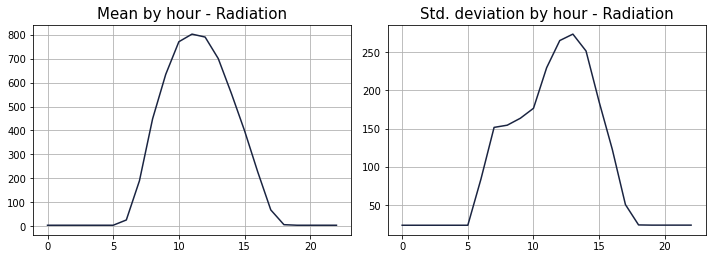

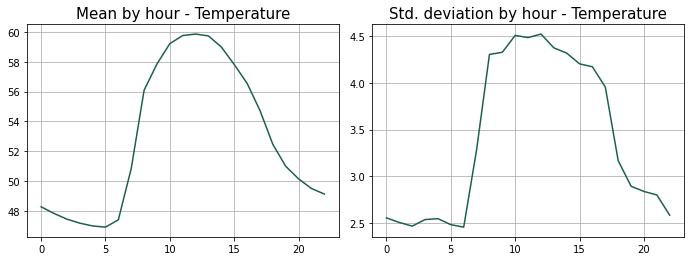

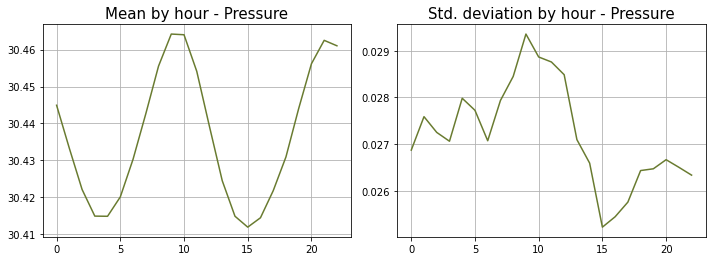

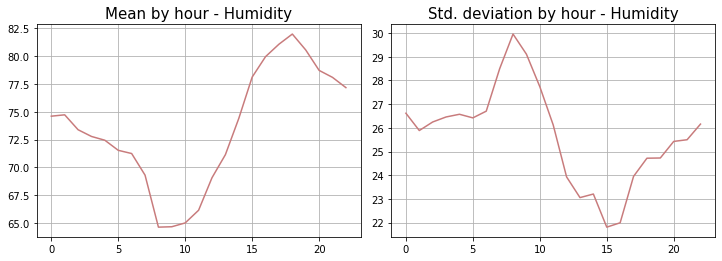

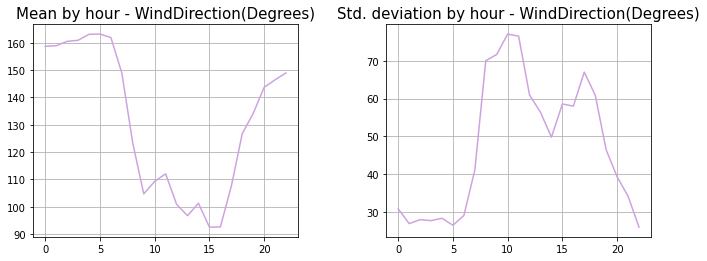

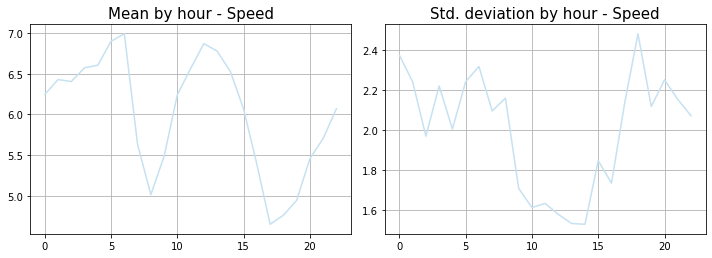

In [20]:
import matplotlib.pyplot as plt
cols=sns.color_palette("cubehelix", len(var_names))
for J in range(6):
  plt.rcParams["figure.figsize"]=[10,20]
  #J=0
  var_name=var_names[J]
  mean_per_hr=np.nan*np.zeros((24))
  std_per_hr=np.nan*np.zeros((24))
  for hr in range(23):
    mean_per_hr[hr]=np.mean(data_tr[time_tr.hour==hr][:,J])
    std_per_hr[hr]=np.std(data_tr[time_tr.hour==hr][:,J])
  #plt.suptitle(var_name,size=20,y=J+1)
  plt.subplot(6,2,2*J+1),plt.title(f'Mean by hour - {var_name}',size=15)
  plt.plot(mean_per_hr,color=cols[J]),plt.grid()
  plt.subplot(6,2,2*J+2),plt.title(f'Std. deviation by hour - {var_name}',size=15)
  plt.plot(std_per_hr,color=cols[J]),plt.grid()
  plt.tight_layout()
  plt.show()

##### VI) **Estandarice** los conjuntos de entrenamiento, validación y test. Tienendo en mente que buscaremos predecir la radiación para las 24 horas futuras definiremos las variables de entrada y salida, realizando una transformación conveniente utilizando la función split_sequence entregada.

In [21]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(data_tr)
# timestep, numero de datos, numero de features de cada dato
# input shape = numero de datos, numero de feature de cada = (24, 8)
data_tr = scaler.transform(data_tr)
data_val = scaler.transform(data_val)
data_tst = scaler.transform(data_tst)


In [22]:
def split_sequence(sequence, n_steps_in, n_steps_out,time_seq):
    X, y , seq_t= list(), list(), list()
    #for i in range(0,len(sequence),n_steps_in):
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in # i + 24
        out_end_ix = end_ix + n_steps_out # + 24
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        # La estructura del sequence corresponde a 24 filas de x (con sus 8 columnas) seguido de 24 filas de y (con sus 8 columnas)
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix,0] # se toman 24 datos para seq_x
        seq_t.append(time_seq[end_ix])
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y) , np.asarray(seq_t)

In [23]:
len_inp=24
len_out=24
x_tr,y_tr,t_tr=split_sequence(data_tr,len_inp,len_out,time_tr)
x_val,y_val,t_val=split_sequence(data_val,len_inp,len_out,time_tr)
x_tst,y_tst,t_tst=split_sequence(data_tst,len_inp,len_out,time_tr)


**Explique** a qué corresponde cada dimensión de las variables de entrada y salida.


 Variables de entrada:  
1° Dimensión: Cantidad de secuencias de la data (número de ejemplos o datos)  
2° Dimensión: Corresponde al largo de cada secuencia  
3° Dimensión: Corresponde a la cantidad features de cada elemento de la secuencia  
Variables de salida:  
1° Dimensión: Cantidad de secuencias de la data (número de ejemplos o datos)  
2° Dimensión: Corresponde al largo de cada secuencia, es decir entrega la radiación para las 24 horas siguientes

In [24]:
x_tr.shape,x_val.shape,x_tst.shape,y_tr.shape,y_val.shape,y_tst.shape

((1935, 24, 6), (378, 24, 6), (378, 24, 6), (1935, 24), (378, 24), (378, 24))

## 1.b) Primera  red recurrente.
Ahora entrenaremos una primera red recurrente LSTM. **Explique** la particularidad de estas redes y **por qué** podría comportarse bien para este tipo de problemas. 

La particularidad de las LSTM es su capacidad para identificar dependencias largas en la data a analizar mientras se controla el problema del desvanecimiento del gradiente y del gradiente explosivo. Esto se lleva a cabo mediante una serie de "bloques LSTM". Cada bloque contiene un estado y compuertas de olvido, entrada y salida. La compuerta de olvido regula si se debe o no olvidar información del estado pasado. La compuerta de entrada regula que tanta importancia darle al input actual. La compuerta de salida regula el peso del output del bloque.  

Estas se podrian comportar bien para este tipo de problemas debido a que estos bloques permiten decidir automaticamente cuando recordar, cuando olvidar
 y cuando mostrar ciertos datos de la secuencia. Esto es extremadamente util para series de tiempo debido a que podremos tomar la cantidad de datos anteriores en el 
 tiempo de forma conveniente para predecir exitosamente el futuro. 
<br> <br> Entrenaremos dos redes recurrentes similares, la primera tan solo utilizará la variable Radiation como entrada para predecir Radiation, caso que llamaremos **univariante**, mientras la segunda utilizará las variables [Radiation, Temperature, Pressure, Humidity, WindDirection(Degrees), Speed] como entrada para predecir Radiation, caso que llamaremos **multivariante**. <br> <br> **Recupere** las funciones utilizadas en la tarea anterior para graficar los errores de entrenamiento, validación y test, y así comparar el rendimiento de ambas redes RNN gráficamente. **Comente**

Para nuestra sorpresa, la red univariante tiene un mejor desempeno. El comportamiento de ambas curvas sigue una tendencia clara; ambas disminuyen en razon similar. Notamos que
al llegar a 40 epochs se obtiene una excelente capacidad de generalizacion. 

Respecto a la red multivariante, se puede apreciar como el error en el conjunto de entrenamiento disminuye constantemente mientras el error en el conjunto de validacion permance constante. Esto es un claro ejemplo de **overfitting**. 


In [48]:
def graph_results(hists,tsts,titles,fig_size=[10,10]):
  if len(hists) == 1:
    fig, ax = plt.subplots(1, sharey=True)
    plt.rcParams["figure.figsize"]=fig_size
    ax.set_title(titles[0])
    ax.plot(hists[0]["loss"],"b.",label="Train_loss")
    ax.plot(hists[0]["val_loss"],"r.",label="Val_loss")
    ax.axhline(y=tsts[0],color="k",linestyle="-.",label="Tst_loss")
    ax.set_xlabel("Epochs"),ax.set_ylabel("MSE Error")
    #ax.set_xlim([0,10])  # <- Puede convenir insertar como entrada a la función límite inferiores y superiores para ajuste manual
    ax.grid()
    plt.tight_layout()
    plt.show()
    return
  plt.rcParams["figure.figsize"]=fig_size
  fig, axes = plt.subplots(1, len(hists), sharey=True) # sharey to keep the same y lims for all subplots. 
                                            # En algunos casos esto puede jugar en contra para una buena visualización -> ver siguiente comentario
  for i,ax in enumerate(axes):
    ax.set_title(titles[i])
    ax.plot(hists[i]["loss"],"b.",label="Train_loss")
    ax.plot(hists[i]["val_loss"],"r.",label="Val_loss")
    ax.axhline(y=tsts[i],color="k",linestyle="-.",label="Tst_loss")
    ax.set_xlabel("Epochs"),ax.set_ylabel("MSE Error")
    #ax.set_xlim([0,10])  # <- Puede convenir insertar como entrada a la función límite inferiores y superiores para ajuste manual
    if i==len(axes)-1: ax.legend()
    ax.grid()
  plt.tight_layout()
  plt.show()

#hists=[hist_1_b_i.history,hist_1_b_ii.history]
#tsts=[test_loss_1_b_i,test_loss_1_b_ii]
#titles=["MSE error v/s epochs [Sigmoidal]","MSE error v/s epochs [ReLU]"]

In [52]:
import tensorflow as tf
from tensorflow.python.keras import models
from tensorflow.python.keras import layers
from tensorflow.python.keras import activations
from tensorflow.python.keras.engine import input_layer
# shape=(24,6) el 24 corresponde al largo de cada secuencia y el 6 a la forma de cada elemento de la secuencia, en nuestro caso 6 columnas.
input_lstm= input_layer.Input(shape=(x_tr.shape[1],1))
rnn=layers.LSTM(units=56,return_sequences=False)(input_lstm)
dens=layers.Dense(len_out, activation='sigmoid')(rnn)
model_1=models.Model(inputs=input_lstm, outputs=dens)
model_1.compile(loss='mse', optimizer='adam')

model_1.summary()
history_1 = model_1.fit(x_tr[:,:,0:1],y_tr, validation_data=(x_val[:,:,0:1],y_val), epochs=40, batch_size=16,verbose=False)

y_pred_1=model_1(x_tst[:,:,0:1])
tst_loss_1=tf.math.reduce_mean(tf.keras.losses.MSE(y_tst, y_pred_1)).numpy()

Model: "model_512"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_515 (InputLayer)       [(None, 24, 1)]           0         
_________________________________________________________________
lstm_986 (LSTM)              (None, 56)                12992     
_________________________________________________________________
dense_516 (Dense)            (None, 24)                1368      
Total params: 14,360
Trainable params: 14,360
Non-trainable params: 0
_________________________________________________________________


In [55]:
input_lstm= input_layer.Input(shape=(x_tr.shape[1:]))
rnn=layers.LSTM(units=56,return_sequences=False)(input_lstm)
dens=layers.Dense(len_out, activation='sigmoid')(rnn)
model_2=models.Model(inputs=input_lstm, outputs=dens)
model_2.compile(loss='mse', optimizer='adam')

model_2.summary()
history_2 = model_2.fit(x_tr,y_tr, validation_data=(x_val,y_val), epochs=40, batch_size=16,verbose=False)
y_pred_2=model_2(x_tst)
tst_loss_2=tf.math.reduce_mean(tf.keras.losses.MSE(y_tst, y_pred_2)).numpy()

Model: "model_513"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_516 (InputLayer)       [(None, 24, 6)]           0         
_________________________________________________________________
lstm_987 (LSTM)              (None, 56)                14112     
_________________________________________________________________
dense_517 (Dense)            (None, 24)                1368      
Total params: 15,480
Trainable params: 15,480
Non-trainable params: 0
_________________________________________________________________


In [56]:
hists = []
tsts = []
titles = []
hists.append(history_1.history)
titles.append("RNN Univariante error vs epochs")
hists.append(history_2.history)
titles.append("RNN Multivariante error vs epochs")
tsts.append(tst_loss_1)
tsts.append(tst_loss_2)

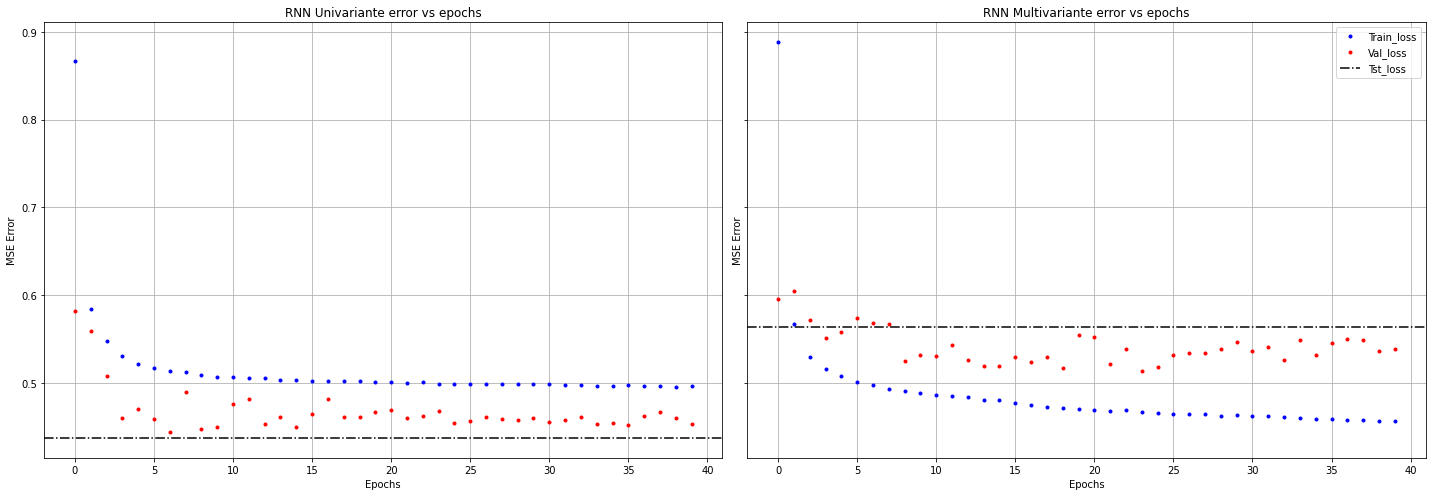

In [57]:
graph_results(hists,tsts,titles, [20,7])

## 1.c) Exploración de profundidad y GRU.

##### I) Exploraremos aumentar la profundidad de la red neuronal. El modelo LSTM original se compone de una sola capa LSTM oculta seguida de una capa de salida estándar. Podríamos decir que nuestra red neuronal posee dos profundidades distintas. La Stacked LSTM es una extensión del modelo LSTM original, la cual tiene múltiples capas LSTM ocultas donde cada capa contiene múltiples celdas de memoria. A la vez, del mismo modo que en la Tarea 1, es posible aumentar la profundidad de la red densa de salida. 

Proceda a probar distintas combinaciones de profundidades de capas LSTM y de capas Densas (contando la capa de salida), para el caso univariado y multivariado. Para mantener un tiempo de ejecución produnte, considere una profunidad LSTM máxima de 2, y una profundidad densa máxima de 2. 
**Grafique y compare** los errores de entrenamiento, validación y test para los distintos casos.  

**Comente:**

Basandonos en los graficos obtenidos, la arquitectura con mejor desempeno es por lejos la conformada por dos capas LSTM apiladas y una capa densa.
Ambas curvas de error presentan una pendiente importante que nos hace conjeturar que con un mayor numero de epochs esta red seguiria mejorando su capacidad de generalizacion.

Respecto a las otras arquitecturas tenemos que:

1. En la arquitectura con una capa LSTM y una densa es posible visualizar principios de overfitting debido a que el error en el conjunto de
entrenamiento disminuye constantemente, mientras que el error de validacion se mantiene constante. 
2. En la arquitectura con una capa LSTM y dos densa la tendencia del error en el conjunto de validacion no es clara, sin embargo hasta la
octava epoch podemos observar que se obtiene un buen modelo sin presencia de overfitting.
3. En la arquitecutra con dos capas LSTM y dos capas densas observamos nuevamente una curva en el conjunto de entrenamiento que disminuye constantemente
mientras que la asociada al conjunto de validacion pareciera mantenerse constante. Esto puede ser un indicio de overfitting.
Este caso es bastante similar al de la arquitectura con una capa LSTM y una densa.


El siguiente código muestra el caso multivariado con profundidades máximas LSTM y Densas. Utilice el número de celdas de memoria y número de neuronas recomendado en el código para las distintas profundidades, al igual que el número de epochs.

**Pregunta:**  
¿Por qué cuando una capa LSTM precede otra capa LSTM es necesario utilizar return_sequences=True?  
**Respuesta:** Porque una LSTM es un tipo de capa recurrente, por lo cual se entrena con secuencias. Así, la salida de la capa previa a una LSTM debe retornar una secuencia. En este caso definimos return_sequence=True para retornar la secuencia completa.  
¿Es necesario/recomendado utilizar return_sequences=False cuando una capa LSTM precede a una capa Densa?  
**Respuesta:** Es recomendado, ya que la capa densa no se entrena con secuencias. Cada unidad de la capa LSTM tendrá como output el último time step
y las distintas conexiones con sus pesos entre las unidades LSTM y las neuronas de la capa densa definirán el output correcto. Podemos decir que el último 
time step acumula selecticamente la información del pasado de la secuencia, es decir las 23 horas previas, por lo que en base a esta información
la red aprende a predecir el output de las 24 horas siguientes.

In [58]:
input_lstm1= input_layer.Input(shape=(x_tr.shape[1:]))
rnn1= layers.LSTM(units=56,return_sequences=False)(input_lstm1) # 2° lstm
dens1= layers.Dense(len_out, activation='sigmoid')(rnn1) # 2° densa
model1= models.Model(inputs=input_lstm1, outputs=dens1)
model1.compile(loss='mse', optimizer='adam')
model1.summary()
history_1 = model1.fit(x_tr,y_tr, validation_data=(x_val,y_val), epochs=10, batch_size=16,verbose=True)
y_pred1= model1(x_tst)
tst_loss1= tf.math.reduce_mean(tf.keras.losses.MSE(y_tst, y_pred1)).numpy()

Model: "model_514"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_517 (InputLayer)       [(None, 24, 6)]           0         
_________________________________________________________________
lstm_988 (LSTM)              (None, 56)                14112     
_________________________________________________________________
dense_518 (Dense)            (None, 24)                1368      
Total params: 15,480
Trainable params: 15,480
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
121/121 [==============================] - 15s 109ms/step - loss: 1.0946 - val_loss: 0.5930
Epoch 2/10
121/121 [==============================] - 12s 103ms/step - loss: 0.5898 - val_loss: 0.5700
Epoch 3/10
121/121 [==============================] - 12s 103ms/step - loss: 0.5360 - val_loss: 0.5434
Epoch 4/10
121/121 [==============================] - 12s 102ms/step - los

In [66]:
input_lstm2= input_layer.Input(shape=(x_tr.shape[1:]))
rnn2=layers.LSTM(units=56,return_sequences=False)(input_lstm2) # 2° lstm
dens2=layers.Dense(32, activation='relu')(rnn2) # 1° densa
dens2=layers.Dense(len_out, activation='sigmoid')(dens2) # 2° densa
model2=models.Model(inputs=input_lstm2, outputs=dens2)
model2.compile(loss='mse', optimizer='adam')
model2.summary()
history_2 = model2.fit(x_tr,y_tr, validation_data=(x_val,y_val), epochs=10, batch_size=16,verbose=True)
y_pred2=model2(x_tst)
tst_loss2=tf.math.reduce_mean(tf.keras.losses.MSE(y_tst, y_pred2)).numpy()

Model: "model_520"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_523 (InputLayer)       [(None, 24, 6)]           0         
_________________________________________________________________
lstm_997 (LSTM)              (None, 56)                14112     
_________________________________________________________________
dense_527 (Dense)            (None, 32)                1824      
_________________________________________________________________
dense_528 (Dense)            (None, 24)                792       
Total params: 16,728
Trainable params: 16,728
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
121/121 [==============================] - 16s 117ms/step - loss: 1.1080 - val_loss: 0.5782
Epoch 2/10
121/121 [==============================] - 13s 107ms/step - loss: 0.5433 - val_loss: 0.5824
Epoch 3/10
121/121 [=========================

In [67]:
input_lstm3= input_layer.Input(shape=(x_tr.shape[1:]))
rnn3=layers.LSTM(units=56,return_sequences=True)(input_lstm3) # 1° lstm
rnn3=layers.LSTM(units=56,return_sequences=False)(rnn3) # 2° lstm
dens3=layers.Dense(len_out, activation='sigmoid')(rnn3) # 2° densa
model3=models.Model(inputs=input_lstm3, outputs=dens3)
model3.compile(loss='mse', optimizer='adam')
model3.summary()
history_3 = model3.fit(x_tr,y_tr, validation_data=(x_val,y_val), epochs=10, batch_size=16,verbose=True)
y_pred3=model3(x_tst)
tst_loss3=tf.math.reduce_mean(tf.keras.losses.MSE(y_tst, y_pred3)).numpy()

Model: "model_521"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_524 (InputLayer)       [(None, 24, 6)]           0         
_________________________________________________________________
lstm_998 (LSTM)              (None, 24, 56)            14112     
_________________________________________________________________
lstm_999 (LSTM)              (None, 56)                25312     
_________________________________________________________________
dense_529 (Dense)            (None, 24)                1368      
Total params: 40,792
Trainable params: 40,792
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
121/121 [==============================] - 29s 205ms/step - loss: 1.0342 - val_loss: 0.6260
Epoch 2/10
121/121 [==============================] - 25s 204ms/step - loss: 0.5721 - val_loss: 0.6032
Epoch 3/10
121/121 [=========================

In [61]:
input_lstm4= input_layer.Input(shape=(x_tr.shape[1:]))
rnn4=layers.LSTM(units=56,return_sequences=True)(input_lstm4) # 1° lstm
rnn4=layers.LSTM(units=56,return_sequences=False)(rnn4) # 2° lstm
dens4=layers.Dense(32, activation='relu')(rnn4) # 1° densa
dens4=layers.Dense(len_out, activation='sigmoid')(dens4) # 2° densa
model4=models.Model(inputs=input_lstm4, outputs=dens4)
model4.compile(loss='mse', optimizer='adam')
model4.summary()
history_4 = model4.fit(x_tr,y_tr, validation_data=(x_val,y_val), epochs=10, batch_size=16,verbose=True)
y_pred4=model4(x_tst)
tst_loss4=tf.math.reduce_mean(tf.keras.losses.MSE(y_tst, y_pred4)).numpy()

Model: "model_517"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_520 (InputLayer)       [(None, 24, 6)]           0         
_________________________________________________________________
lstm_992 (LSTM)              (None, 24, 56)            14112     
_________________________________________________________________
lstm_993 (LSTM)              (None, 56)                25312     
_________________________________________________________________
dense_522 (Dense)            (None, 32)                1824      
_________________________________________________________________
dense_523 (Dense)            (None, 24)                792       
Total params: 42,040
Trainable params: 42,040
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
121/121 [==============================] - 29s 204ms/step - loss: 1.0800 - val_loss: 0.6810
Epoch 2/10
121/1

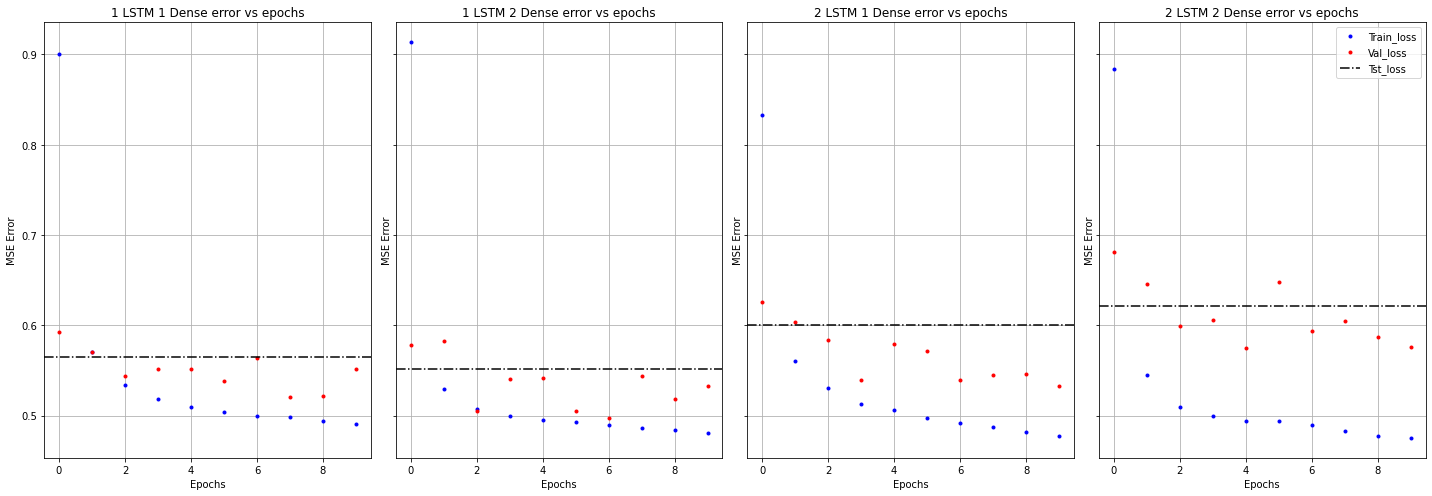

In [68]:
hists_1c = []
tsts_1c = []
titles_1c = []
hists_1c.append(history_1.history)
titles_1c.append("1 LSTM 1 Dense error vs epochs")
hists_1c.append(history_2.history)
titles_1c.append("1 LSTM 2 Dense error vs epochs")
hists_1c.append(history_3.history)
titles_1c.append("2 LSTM 1 Dense error vs epochs")
hists_1c.append(history_4.history)
titles_1c.append("2 LSTM 2 Dense error vs epochs")
tsts_1c.append(tst_loss1)
tsts_1c.append(tst_loss2)
tsts_1c.append(tst_loss3)
tsts_1c.append(tst_loss4)

graph_results(hists_1c,tsts_1c,titles_1c, [20,7])

##### II) Añadiremos entradas a la capa Densa que indiquen la hora del día de forma bi-dimensional, semejante a un reloj, y una variable dummy que indica si es de día o noche. Ejecute el siguiente código para generar las entradas adicionales, y **añada la entrada** a la arquitectura entregada. Esta forma de ingresar variables adicionales a la capa densa se asemeja a la arquitectura skip-connections vista en la Tarea 1. **La hora que se entrega para indicar si es de día o noche es intencionalmente erronea**. Utilizando los datos de radiación del conjunto de entrenamiento **deberá definir las horas de día y noche de manera justificada**. 

**Comente** sobre los resultados obtenidos.  
La radiación que recibimos proviene principalmente desde el sol, por lo que, cuando se detecta que esta comienza a aumentar, es porque el sol
está apareciendo en el horizonte, es decir, comenzando el día, la misma lógica es aplicable para cuando la radiación comienza a desaparecer, en tal caso
el sol está ocultándose, y por tanto la noche está comenzando. Se nota una mejora en el rendimiento de la red al añadir los inputs de la hora del día
y si es que es de día o de noche, esto ya que, la radiación depende estrechamente de si el sol está presente o no en el momento de la medición.

**Pregunta:** ¿Por qué puede resultar beneficioso representar la hora del día de manera bidimensional en lugar de unidimensional?  
**Respuesta:** Las horas del día siguen un comportamiento cíclico, esto no queda modelado en una representación unidimensional, por lo que, nuestra red
no podra aprender o notar la característica cíclica del feature. Por otro lado, si utilizamos una representación bidimensional en un plano podemos dibujar
un circulo con los datos, con esta representación la red puede aprender la naturaleza cíclica de la data.


In [34]:
daytimehrs=[5,18]

In [70]:
from math import *
hour_1_tr=np.asarray(np.sin(2*pi*pd.to_datetime(t_tr).hour/24)).reshape(-1,1)
hour_2_tr=np.asarray(np.cos(2*pi*pd.to_datetime(t_tr).hour/24)).reshape(-1,1)
dummy_tr=(1*(pd.to_datetime(t_tr).hour<daytimehrs[1])*(pd.to_datetime(t_tr).hour>daytimehrs[0])).reshape(-1,1)
hour_1_val=np.asarray(np.sin(2*pi*pd.to_datetime(t_val).hour/24)).reshape(-1,1)
hour_2_val=np.asarray(np.cos(2*pi*pd.to_datetime(t_val).hour/24)).reshape(-1,1)
dummy_val=(1*(pd.to_datetime(t_val).hour<daytimehrs[1])*(pd.to_datetime(t_val).hour>daytimehrs[0])).reshape(-1,1)
hour_1_tst=np.asarray(np.sin(2*pi*pd.to_datetime(t_tst).hour/24)).reshape(-1,1)
hour_2_tst=np.asarray(np.cos(2*pi*pd.to_datetime(t_tst).hour/24)).reshape(-1,1)
dummy_tst=(1*(pd.to_datetime(t_tst).hour<daytimehrs[1])*(pd.to_datetime(t_tst).hour>daytimehrs[0])).reshape(-1,1)

ext_tr=np.concatenate((hour_1_tr,hour_2_tr,dummy_tr),axis=1)
ext_val=np.concatenate((hour_1_val,hour_2_val,dummy_val),axis=1)
ext_tst=np.concatenate((hour_1_tst,hour_2_tst,dummy_tst),axis=1)

print(hour_1_tr)

[[ 0.00000000e+00]
 [ 2.58819045e-01]
 [ 5.00000000e-01]
 ...
 [ 1.22464680e-16]
 [-2.58819045e-01]
 [-5.00000000e-01]]


In [71]:
from keras.layers import concatenate

input_lstm5= input_layer.Input(shape=(x_tr.shape[1:]))
rnn5=layers.LSTM(units=56,return_sequences=True)(input_lstm5) # 1° lstm
rnn5=layers.LSTM(units=56,return_sequences=False)(rnn5) # 2° lstm
input_clock5= input_layer.Input(shape=(3))
input_dense5=concatenate([rnn5, input_clock5])
dens5=layers.Dense(32, activation='relu')(input_dense5) # 1° densa
dens5=layers.Dense(len_out, activation='sigmoid')(dens5) # 2° densa
model5=models.Model(inputs=[input_lstm5,input_clock5], outputs=dens5)
model5.compile(loss='mse', optimizer='adam')
model5.summary()
history_5 = model5.fit([x_tr,ext_tr],y_tr, validation_data=([x_val,ext_val],y_val), epochs=10, batch_size=16,verbose=True)
y_pred5=model5([x_tst,ext_tst])
tst_loss5=tf.math.reduce_mean(tf.keras.losses.MSE(y_tst, y_pred5)).numpy()

Model: "model_523"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_527 (InputLayer)          [(None, 24, 6)]      0                                            
__________________________________________________________________________________________________
lstm_1002 (LSTM)                (None, 24, 56)       14112       input_527[0][0]                  
__________________________________________________________________________________________________
lstm_1003 (LSTM)                (None, 56)           25312       lstm_1002[0][0]                  
__________________________________________________________________________________________________
input_528 (InputLayer)          [(None, 3)]          0                                            
__________________________________________________________________________________________

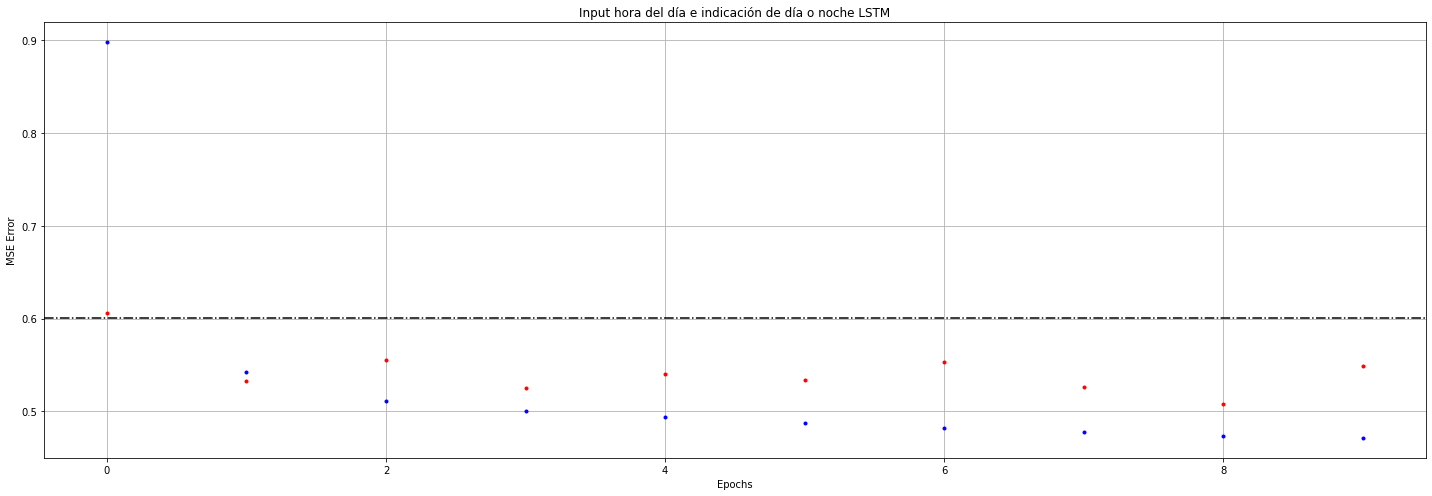

In [72]:
hists_1c2 = []
tsts_1c2 = []
titles_1c2 = []
hists_1c2.append(history_5.history)
titles_1c2.append("Input hora del día e indicación de día o noche LSTM")
tsts_1c2.append(tst_loss5)

graph_results(hists_1c2,tsts_1c2,titles_1c2, [20,7])

##### III) Entrene la misma arquitectura que en la pregunta anterior utilizando unidades GRU en lugar de LSTM. **Explique la diferencia entre GRU y LSTM**. **Compare** los resultados con los obtenidos en el punto anterior.

**Diferencia:** La diferencia principal es en las puertas que tiene cada tipo de unidad. La LSTM tiene 3 puertas: input, output y forget gate (puerta de olvido), en cambio la GRU tiene 2 puertas: reset y update gate. Por lo tanto, se puede ver a la GRU como una versión simplificada de la LSTM, para la GRU una misma puerta controla ambos, el factor de olvido y la decisión de actualizar el estado de la unidad. Mientras que en la LSTM esta tiene un puerta especifica para cada factor. Podemos ver la equivalencia entre las puertas input y forget gates de la LSTM con la puerta de update de la GRU. Esto claramente simplifica a la GRU pero la hace menos precisa, por lo que si se requiere mayor precisión se debería implementar LSTM, sin embargo esto requerirá mayor capacidad de cómputo, por lo que, si se puede perder un poco de precisión la GRU sería una buena opción para reducir los tiempos de computación. Por lo que, el objetivo es reducir tiempos de computación y seguir teniendo la capacidad de recordar u olvidar parcialemente elementos de instantes previos.  
**Resultados:**
La arquitectura que utiliza LSTM tiene un menor error de validación y entrenamiento respecto de la arquitectura con GRU, sin embargo, se observa que
los tiempos de entrenamiento de la LSTM son considerablemente mayores que cuando se usan unidades GRU.

In [73]:
#input_lstm= input_layer.Input(shape=(x_tr.shape[1:]))
#rnn=layers.GRU(units=56,return_sequences=True)(input_lstm) # 1° capa gru

input_gru6= input_layer.Input(shape=(x_tr.shape[1:]))
rnn6=layers.GRU(units=56,return_sequences=True)(input_gru6)
rnn6=layers.GRU(units=56,return_sequences=False)(rnn6)
input_clock6= input_layer.Input(shape=(3))
input_dense6=concatenate([rnn6, input_clock6])
dens6=layers.Dense(32, activation='relu')(input_dense6) # 1° densa
dens6=layers.Dense(len_out, activation='sigmoid')(dens6) # 2° densa
model6=models.Model(inputs=[input_gru6,input_clock6], outputs=dens6)
model6.compile(loss='mse', optimizer='adam')
model6.summary()
history_6 = model6.fit([x_tr,ext_tr],y_tr, validation_data=([x_val,ext_val],y_val), epochs=10, batch_size=16,verbose=True)
y_pred6=model6([x_tst,ext_tst])
tst_loss6=tf.math.reduce_mean(tf.keras.losses.MSE(y_tst, y_pred6)).numpy()

Model: "model_524"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_529 (InputLayer)          [(None, 24, 6)]      0                                            
__________________________________________________________________________________________________
gru_2 (GRU)                     (None, 24, 56)       10584       input_529[0][0]                  
__________________________________________________________________________________________________
gru_3 (GRU)                     (None, 56)           18984       gru_2[0][0]                      
__________________________________________________________________________________________________
input_530 (InputLayer)          [(None, 3)]          0                                            
__________________________________________________________________________________________

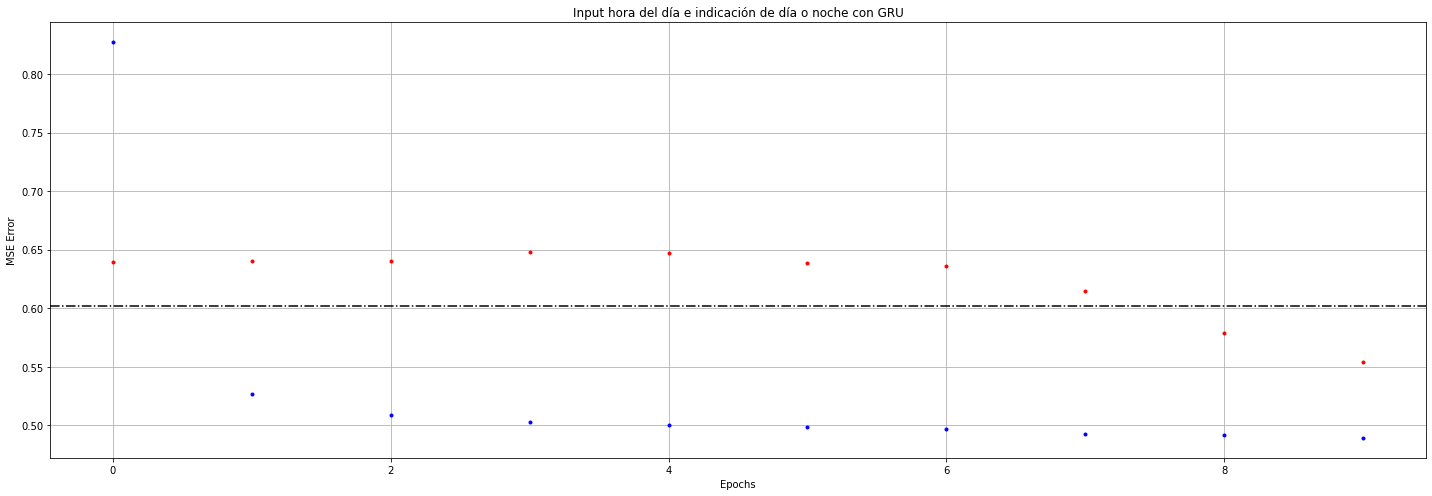

In [74]:
hists_1c3 = []
tsts_1c3 = []
titles_1c3 = []
hists_1c3.append(history_6.history)
titles_1c3.append("Input hora del día e indicación de día o noche con GRU")
tsts_1c3.append(tst_loss6)

graph_results(hists_1c3,tsts_1c3,titles_1c3, [20,7])

##### IV) Con la red con mejor rendimiento, respecto al error de validación, en este punto 1.c) ejecute el siguiente código y saque conclusiones del violin plot.

**Pregunta:** ¿Qué hace un violin plot?

**Respuesta:** Un violin plot permite obtener mayor informacion (con respecto a graficos tradicionales) sobre la distribucion de los datos. Incluye la informacion
que nos entrega un boxplot, sin embargo esta se complementa con una especie de graficas verticales que permite visualizar la distribucion de los datos alrededor de la mediana.,

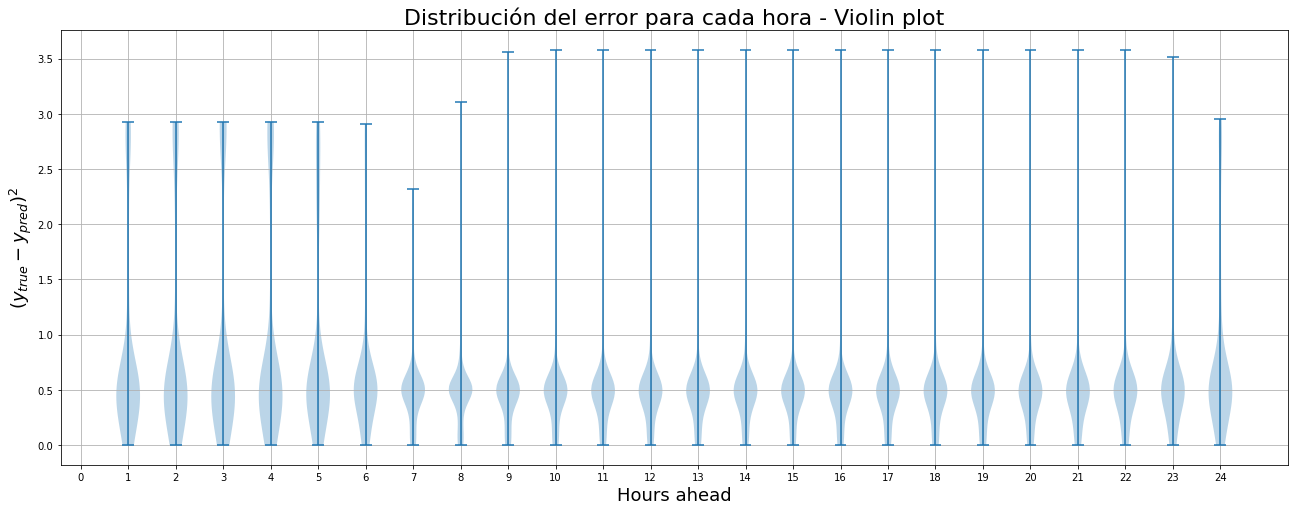

In [40]:
y_pred=model5([x_tst,ext_tst])
tst_loss=((y_tst- y_pred)**2).numpy()
plt.rcParams["figure.figsize"]=[22,8]
plt.title("Distribución del error para cada hora - Violin plot",size=22)
plt.violinplot(tst_loss)
plt.xlabel("Hours ahead",size=18)
plt.ylabel("$(y_{true}-y_{pred})^2$",size=18)
plt.xticks(np.arange(25))
plt.grid()
plt.show()

## 1.d) Parameters & hyperparameters tunning. 

##### I) Como se habrá percatado, existe una **inmensa** cantidad de hiperparámetros que uno puede ajustar en las arquitecturas de redes neuronales (learning rate, profundidad de red, n° de neuronas en cada capa, optimizador, cantidad de epochs), también se puede considerar como hiperparámetro si es que incluir o no métodos tales como batch normalization, regularización L1/L2 o dropout en la red neuronal, a la vez habrá qué decidir dónde situar estos métodos, y cómo ajustar sus propios hiperparámetros. Aún más, también es posible experimentar con la manipulación del dataset, p.ej decidir si usar una entrada univariada, multivariada, o un punto intermedio (y si es un punto intermedio qué variables ocupar), también es posible variar el largo de las series de tiempo de entrada.

Prepare un código para hacer **Random Search**, dado que los tiempos de entrenamiento serán desproporcionados, **NO ENTRENE** las redes neuronales, pero evalúe en el conjunto de validación como si las hubiese entrenado para escoger los ""mejores"" parámetros & hiperparámetros de la red neuronal. Mantenga el objetivo de predecir la radiación para las siguientes 24 horas. **Imprima** (print) los valores de los parámetros & hiperparámetros de la red que se esté evaluando, indicando a qué corresponde, y recolecte el error de validación. Realice un Random Search de largo 100, apóyese en el código entregado, **expándalo** desde la búsqueda de 3 hiperparámetros/parámetros hasta una búsqueda de al menos **12** hiperparámetros/parámetros, puede escoger de los ejemplos dados en el primer párrafo de este ítem, o bien escoger por su propia cuenta. El código debe ser funcional, es decir, las _arquitecturas/manipulaciones del dataset_ indicadas por los hiperparámetros/parámetros deben ser efectivamente aplicadas en la construcción de la red neuronal y/o manipulación de datos. Note que en el código dado, un hiperparámetro a ajustar es recurrent dropout. 
**Indique** cuál fue la mejor arquitectura encontrada según el error de validación.

**Respuesta:** La mejor arquitectura obtuvo un error de validacion 1.0678873:

54 ° --->  Profundidad rnn:  1  | N° neuronas:  [38]  | Recurrent dropout:  0.44641488683275454  | batch_normalization:  False  | use_bias:  True  | unit_forget_bias:  False
 | bias_regularizer:  l2  | dropout:  0.6926363426344402  | kernel_initializer:  glorot_normal  | activation:  tanh  | recurrent_activation:  None
 | bias_initializer:  ones
Validation error:  1.0678873

**Preguntas:** 

i) ¿Qué alternativas al Random Search existen? Nombre al menos una.   
**Respuesta:**  
1. **Grid Search:**  Es un método basado en fuerza bruta. Primero se define un subconjunto del espacio de hiperparámetros especificado manualmente,
esto se puede hacer definiendo los límites a probar en los hiperparámetros y utilizar un arange de una cantidad específica de valores entre el intervalo
definido, con eso tendremos definida nuestra grilla de hiperparámetros y se probará la arquitectura con los distintos puntos de la grilla, en caso de 
probar 2 hiperparámetros, cada punto de la grilla es la combinación de dos valores de hiperparámetro.  
2. **Optimización Bayesiana:** Se basa en el teorema de bayes, busca utilizar una estimación previa de los hiperparámetros para construir un modelo estadístico
inicial, el cual se perfeccionará con la información actual para obtener iterativamente una configuración óptima de hiperparámetros a probar de forma de maximizar la 
información obtenida.  
3. **Optimización Evolutiva:** Utiliza algoritmos evolutivos para encontrar la combinación de parámetros óptima para la arquitectura y data específica a través
la generación de mutaciones y cruzamientos en los individuos (conjunto de instancias de hiperparámetros).  

ii) ¿Qué hace el método recurrent dropout?

**Respuesta:** Asiginar un valor entre 0 y 1 que indica la probabilidad de apagar cada neurona para calcular la activacion del estado recurrente con una cantidad menor de neuronas.

In [41]:
val_h=[]
for random_search in range(100):
  prof_rnn = np.random.randint(1,4)
  neu_rnn = [np.random.randint(20,40) for t in range(prof_rnn)]
  rec_drop = np.random.uniform(0,0.7)
  batch_norm = bool(random.getrandbits(1))
  use_bias = bool(random.getrandbits(1))
  unit_forget_bias = bool(random.getrandbits(1))
  bias_regularizer = "l1" if random.getrandbits(1) else "l2"
  dropout = np.random.uniform(0,0.7)
  kernel_initializer="glorot_uniform" if  bool(random.getrandbits(1)) else "glorot_normal"
  aux_af = np.random.randint(0,3)
  activation_func = "relu" if (aux_af == 0) else ("sigmoid" if (aux_af == 1) else "tanh")
  aux_afr = np.random.randint(0,4)
  recurrent_act_func = "relu" if (aux_afr == 0) else ( "sigmoid" if (aux_afr == 1) else "tanh" if (aux_afr == 2) else None)
  bias_initializer= "zeros" if random.getrandbits(1) else "ones"
  
  input_lstm= input_layer.Input(shape=(x_tr.shape[1:]))
  for i,neu in enumerate(neu_rnn):
    if i==0:
      if len(neu_rnn) > 1: 
        rnn=layers.LSTM(units=neu_rnn[0],return_sequences=True,recurrent_dropout=rec_drop, use_bias = use_bias, unit_forget_bias = unit_forget_bias, bias_regularizer = bias_regularizer, dropout = dropout, kernel_initializer = kernel_initializer, activation=activation_func, recurrent_activation = recurrent_act_func, bias_initializer = bias_initializer)(input_lstm)
      else:
        rnn=layers.LSTM(units=neu_rnn[0],return_sequences=False,recurrent_dropout=rec_drop, use_bias = use_bias, unit_forget_bias = unit_forget_bias, bias_regularizer = bias_regularizer, dropout = dropout, kernel_initializer = kernel_initializer, activation=activation_func, recurrent_activation = recurrent_act_func, bias_initializer = bias_initializer)(input_lstm)
    else: rnn=layers.LSTM(units=56,return_sequences=(i+1<prof_rnn),recurrent_dropout=rec_drop)(rnn)
    #else: rnn=layers.LSTM(units=neu_rnn[i],return_sequences=(i<prof_rnn),recurrent_dropout=rec_drop)(rnn)
    if batch_norm==1: rnn = layers.BatchNormalization()(rnn)
  dens=layers.Dense(len_out, activation='sigmoid')(rnn)
  model=models.Model(inputs=input_lstm, outputs=dens)
  model.compile(loss='mse', optimizer='adam')
  y_pred=model(x_val)
  val_loss=tf.math.reduce_mean(tf.keras.losses.MSE(y_val, y_pred)).numpy()
  print(random_search+1,"° --->  Profundidad rnn: ",prof_rnn, " | N° neuronas: ", neu_rnn, " | Recurrent dropout: ", rec_drop, " | batch_normalization: ",
   batch_norm, " | use_bias: ", use_bias, " | unit_forget_bias: ", unit_forget_bias)
  print(" | bias_regularizer: ", bias_regularizer, " | dropout: ", dropout, " | kernel_initializer: ", kernel_initializer, " | activation: ", activation_func, " | recurrent_activation: ", recurrent_act_func)
  print(" | bias_initializer: ", bias_initializer)
  val_h.append(val_loss)
  print("Validation error: ",val_loss)
  print("-"*120)

1 ° --->  Profundidad rnn:  2  | N° neuronas:  [37, 23]  | Recurrent dropout:  0.33113132034048104  | batch_normalization:  False  | use_bias:  False  | unit_forget_bias:  False
 | bias_regularizer:  l2  | dropout:  0.5676018936381785  | kernel_initializer:  glorot_uniform  | activation:  tanh  | recurrent_activation:  tanh
 | bias_initializer:  zeros
Validation error:  1.1123122
------------------------------------------------------------------------------------------------------------------------
2 ° --->  Profundidad rnn:  1  | N° neuronas:  [33]  | Recurrent dropout:  0.6470478188002335  | batch_normalization:  True  | use_bias:  False  | unit_forget_bias:  True
 | bias_regularizer:  l2  | dropout:  0.20695704536754822  | kernel_initializer:  glorot_uniform  | activation:  tanh  | recurrent_activation:  None
 | bias_initializer:  zeros
Validation error:  1.1057479
-----------------------------------------------------------------------------------------------------------------------

##### II) Implemente sobre el código de Random Search la funcionalidad de realizar Cross-Validation con 5 Folds para cada red neuronal creada en el proceso de Random Search. Dado que se está trabajando con series de tiempo ocupe la función TimeSeriesSplit. Nuevamente **NO ENTRENE** las redes neuronales. El conjunto de entrenamiento y validación deben ser uno inicialmente para luego ser divididos en cada Fold, el conjunto de test se debiese mantener hasta el final. Calcule el error en el conjunto de validación de cada Fold y use el promedio de los 5 Folds para evaluar el rendimiento de cada red neuronal, encuentre los ""mejores"" parámetros/hiperparámetros basado en estos promedios.

**Preguntas:**

i) Visite la página https://scikit-learn.org/stable/modules/cross_validation.html . **Nombre y explique** el método TimeSeriesSplit y al menos otros 3 métodos de cross-validation. ¿Por qué time series split es adecuado para nuestro caso?  
**Respuesta:** El método TimeSeriesSplit es una variación del método K-fold que retorna los primeros K folds como conjunto de entrenamiento y el fold restante
como conjunto de test. A diferencia de los métodos de Cross-validation estándar, los conjuntos de entrenamiento sucesivos son superconjuntos de los conjuntos anteriores.  
1. **K-fold cross validation:** El data set original es partido equitativamente en k subpartes o folds. En cada iteración un fold es seleccionado como data de
validación y el resto de folds son la data de entrenamiento.  
2. **Repeated random subsampling validation:** En cada iteración se selecciona aleatoriamente la data de entrenamiento y validación.  
3. **Stratified k-fold cross-validation:** En casa iteración el dataset es particionado en k folds, tal que la data de validación tenga un número igual de instancias
de clases objetivo. Esto resuelve problemas de datasets desbalanceados.  
4. **Leave-one-out cross-validation:** Técnica de cross-validation exhaustiva, para un dataset dado con n filas, la priemra fila se selecciona para validación, y el resto
se usan para entrenar el modelo. En la siguiente iteración, la segunda fila se selecciona para validación y el resto para entrenar el modelo, y así sucesivamente hasta
que la última fila se seleccione para validación.

ii) ¿Cuáles son los fundamentos de Cross Validation en general (como herramienta de selección de hiperparámetros)?

**Respuesta:** El fundamento principal es comparar modelos que difieren en sus hiperparámetros y elegir el mejor. Para hacer esto el data set 
se debe dividir en pequeños folds (normalmente 5), luego cada modelo es entrenado y testeado en datasets distintos (la eleccion de estos depende del tipo de cross validation)
para finalmente elegir aquel que presenta un mejor desempeño en promedio.

In [42]:
from sklearn.model_selection import TimeSeriesSplit
data_tr_val, time_tr_val = data_hr[:int(data_hr.shape[0]*0.85)],time_hr[:int(data_hr.shape[0]*0.85)] # DIVIDE IN EACH FOLD
data_tst, time_tst = data_hr[int(data_hr.shape[0]*0.85):],time_hr[int(data_hr.shape[0]*0.85):] # KEEP IT UNTIL THE END
# se debiese estandarizar en cada Fold ajustando el scaler con la data de entrenamiento que se genere

val_h=[]
for random_search in range(100):
  prof_rnn = np.random.randint(1,4)
  neu_rnn = [np.random.randint(20,40) for t in range(prof_rnn)]
  rec_drop = np.random.uniform(0,0.7)
  batch_norm = bool(random.getrandbits(1))
  use_bias = bool(random.getrandbits(1))
  unit_forget_bias = bool(random.getrandbits(1))
  bias_regularizer = "l1" if random.getrandbits(1) else "l2"
  dropout = np.random.uniform(0,0.7)
  kernel_initializer="glorot_uniform" if  bool(random.getrandbits(1)) else "glorot_normal"
  aux_af = np.random.randint(0,3)
  activation_func = "relu" if (aux_af == 0) else ("sigmoid" if (aux_af == 1) else "tanh")
  aux_afr = np.random.randint(0,4)
  recurrent_act_func = "relu" if (aux_afr == 0) else ( "sigmoid" if (aux_afr == 1) else "tanh" if (aux_afr == 2) else None)
  bias_initializer= "zeros" if random.getrandbits(1) else "ones"
  tscv = TimeSeriesSplit(n_splits=4)

  losses = 0
  for train_index, val_index in tscv.split(data_tr_val):

    fold_data_train, fold_data_val = data_tr_val[train_index], data_tr_val[val_index]

    scaler = StandardScaler()
    scaler.fit(fold_data_train)
    fold_data_train = scaler.transform(fold_data_train)
    fold_data_val = scaler.transform(fold_data_val)


    #fold_time_val, fold_time_test = time_tr_val[val_index], time_tst[test_index]
    #y_val, y_test = data_tst[val_index], data_tst[test_index]
    #t_val, t_test = time_tr_val[val_index], time_tr_val[test_index]

    x_train,y_train,t_train = split_sequence(fold_data_train,len_inp,len_out,time_tr_val)
    x_val,y_val,t_val=split_sequence(fold_data_val,len_inp,len_out,time_tr_val)
    #x_val,y_val,t_val=split_sequence(val,len_inp,len_out,time_tr_val)
    
    input_lstm= input_layer.Input(shape=(x_tr.shape[1:]))
    for i,neu in enumerate(neu_rnn):
      if i==0:
        if len(neu_rnn) > 1: 
          rnn=layers.LSTM(units=neu_rnn[0],return_sequences=True,recurrent_dropout=rec_drop, use_bias = use_bias, unit_forget_bias = unit_forget_bias, bias_regularizer = bias_regularizer, dropout = dropout, kernel_initializer = kernel_initializer, activation=activation_func, recurrent_activation = recurrent_act_func, bias_initializer = bias_initializer)(input_lstm)
        else:
          rnn=layers.LSTM(units=neu_rnn[0],return_sequences=False,recurrent_dropout=rec_drop, use_bias = use_bias, unit_forget_bias = unit_forget_bias, bias_regularizer = bias_regularizer, dropout = dropout, kernel_initializer = kernel_initializer, activation=activation_func, recurrent_activation = recurrent_act_func, bias_initializer = bias_initializer)(input_lstm)
      else: rnn=layers.LSTM(units=56,return_sequences=(i+1<prof_rnn),recurrent_dropout=rec_drop)(rnn)
      #else: rnn=layers.LSTM(units=neu_rnn[i],return_sequences=(i<prof_rnn),recurrent_dropout=rec_drop)(rnn)
      if batch_norm==1: rnn = layers.BatchNormalization()(rnn)
    dens=layers.Dense(len_out, activation='sigmoid')(rnn)
    model=models.Model(inputs=input_lstm, outputs=dens)
    model.compile(loss='mse', optimizer='adam')
    print(y_pred.shape)
    y_pred=model(x_val)
    val_loss=tf.math.reduce_mean(tf.keras.losses.MSE(y_val, y_pred)).numpy()
    losses = losses+val_loss
  ##val_losses.append(losses/5)
  losses = losses/5
  print(random_search+1,"° --->  Profundidad rnn: ",prof_rnn, " | N° neuronas: ", neu_rnn, " | Recurrent dropout: ", rec_drop, " | batch_normalization: ",
   batch_norm, " | use_bias: ", use_bias, " | unit_forget_bias: ", unit_forget_bias)
  print(" | bias_regularizer: ", bias_regularizer, " | dropout: ", dropout, " | kernel_initializer: ", kernel_initializer, " | activation: ", activation_func, " | recurrent_activation: ", recurrent_act_func)
  print(" | bias_initializer: ", bias_initializer)
  val_h.append(losses)
  print("Validation error: ",losses)
  print("-"*120)

(378, 24)
(434, 24)
(434, 24)
(434, 24)
1 ° --->  Profundidad rnn:  2  | N° neuronas:  [31, 33]  | Recurrent dropout:  0.2108243364106783  | batch_normalization:  True  | use_bias:  False  | unit_forget_bias:  False
 | bias_regularizer:  l2  | dropout:  0.30642850272219824  | kernel_initializer:  glorot_uniform  | activation:  relu  | recurrent_activation:  tanh
 | bias_initializer:  zeros
Validation error:  0.9467254400253295
------------------------------------------------------------------------------------------------------------------------
(434, 24)
(434, 24)
(434, 24)
(434, 24)
2 ° --->  Profundidad rnn:  2  | N° neuronas:  [22, 33]  | Recurrent dropout:  0.26252226244259885  | batch_normalization:  False  | use_bias:  False  | unit_forget_bias:  True
 | bias_regularizer:  l1  | dropout:  0.021751620318583464  | kernel_initializer:  glorot_uniform  | activation:  relu  | recurrent_activation:  relu
 | bias_initializer:  zeros
Validation error:  0.9465900659561157
---------------